# Fine Tuning 

## Binary

In [12]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128, device='cpu'):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.device = device
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten().to(self.device),
            'attention_mask': encoding['attention_mask'].flatten().to(self.device),
            'label': torch.tensor(label, dtype=torch.long, device=self.device)
        }

def train_sentiment_model(data, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Initialize BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model = model.to(device)
    
    # Create dataset
    dataset = SentimentDataset(
        data['text'].values, 
        data['label'].values, 
        tokenizer,
        device=device
    )
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
    
    # Training setup
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    
    # Training loop
    num_epochs = 10
    print(f"Starting training on device: {device}")
    
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        
        for batch in progress_bar:
            optimizer.zero_grad()
            
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['label']
            )
            
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    print("Training completed!")
    return model, tokenizer

# Sample data
data = {
    'text': [
        'This movie was great!',
        'Terrible waste of time',
        'I loved this film',
        'Worst movie ever',
        'Highly recommended',
    ],
    'label': [1, 0, 1, 0, 1]  # 1 for positive, 0 for negative
}
df = pd.DataFrame(data)

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, tokenizer = train_sentiment_model(df, device)

# Test prediction
def predict_sentiment(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    return {
        'positive': prediction[0][1].item(),
        'negative': prediction[0][0].item()
    }

# Test the model
test_text = "This is an amazing movie!"
prediction = predict_sentiment(test_text, model, tokenizer, device)
print(f"\nTest prediction for '{test_text}':")
print(f"Positive: {prediction['positive']:.2%}")
print(f"Negative: {prediction['negative']:.2%}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training on device: cuda


Epoch 1/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/3 [00:00<?, ?it/s]

Training completed!

Test prediction for 'This is an amazing movie!':
Positive: 82.03%
Negative: 17.97%


##  Multiclass

In [13]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128, device='cpu'):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.device = device
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten().to(self.device),
            'attention_mask': encoding['attention_mask'].flatten().to(self.device),
            'label': torch.tensor(label, dtype=torch.long, device=self.device)
        }

def train_sentiment_model(data, device='cuda' if torch.cuda.is_available() else 'cpu'):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    model = model.to(device)
    
    dataset = SentimentDataset(
        data['text'].values, 
        data['label'].values, 
        tokenizer,
        device=device
    )
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    
    num_epochs = 10
    print(f"Starting training on device: {device}")
    
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        
        for batch in progress_bar:
            optimizer.zero_grad()
            
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['label']
            )
            
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    print("Training completed!")
    return model, tokenizer

# Sample data with neutral class
data = {
    'text': [
        'This movie was great!',
        'Terrible waste of time',
        'The film was okay, nothing special',
        'I loved this film',
        'Worst movie ever',
        'It was decent, had its moments',
        'Highly recommended',
        'Average movie, wouldn\'t watch again',
    ],
    'label': [2, 0, 1, 2, 0, 1, 2, 1]  # 0: negative, 1: neutral, 2: positive
}
df = pd.DataFrame(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, tokenizer = train_sentiment_model(df, device)

def predict_sentiment(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    return {
        'negative': prediction[0][0].item(),
        'neutral': prediction[0][1].item(),
        'positive': prediction[0][2].item()
    }

# Test prediction
test_text = "This movie was interesting but had some flaws"
prediction = predict_sentiment(test_text, model, tokenizer, device)
print(f"\nTest prediction for '{test_text}':")
print(f"Negative: {prediction['negative']:.2%}")
print(f"Neutral: {prediction['neutral']:.2%}")
print(f"Positive: {prediction['positive']:.2%}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training on device: cuda


Epoch 1/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/4 [00:00<?, ?it/s]

Training completed!

Test prediction for 'This movie was interesting but had some flaws':
Negative: 13.06%
Neutral: 19.11%
Positive: 67.83%


# Run LLM on local using [Ollama](https://ollama.com/)

In [9]:
import ollama

MODEL_NAME = "mannix/gemma2-9b-simpo"
SYSTEM_PROMPT = """Conduct comprehensive analysis to determine whether the provided text content relates to artificial intelligence domains, technologies, or applications. Upon positive identification, apply taxonomic classification according to the following framework:

Classification Categories:
- Development: Novel AI technologies, architectural innovations, research breakthroughs, algorithmic advancements
- Application: Implementation of existing AI technologies in specific domains or practical use cases  
- Other: AI-related content including theoretical discourse, policy considerations, ethical frameworks, 
or general discussion without specific technical or implementation focus

For all positive classifications, specify the relevant technical domain or field of application 
(e.g., Natural Language Processing, Computer Vision, Healthcare AI, Autonomous Systems, Machine Learning Operations, ecc.).

Output Format Requirements:
Provide response in strict format - yes|category|field OR no|| with no additional commentary or explanation."""

def analyze_text(text):
    try:
        response = ollama.chat(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": f"TEXT: {text}"}
            ]
        )
        
        # Parse response
        result = response['message']['content'].strip().lower()
        is_ai, category, field = result.split('|')
        
        print("\nAnalysis Results:")
        print(f"AI Related: {'YES' if is_ai == 'yes' else 'NO'}")
        if is_ai == 'yes':
            print(f"Category: {category.title()}")
            print(f"Field: {field.title()}")
            
    except Exception as e:
        print(f"\nError: {str(e)}")

# Simple text input loop
print("AI Text Analyzer - Type 'exit' to quit\n")
while True:
    text = input("Enter text to analyze: ").strip()
    
    if text.lower() == 'exit':
        break
        
    if len(text) < 20:
        print("Please enter at least 20 characters\n")
        continue
        
    analyze_text(text)

print("\n" + "="*50 + "\n")



AI Text Analyzer - Type 'exit' to quit

Enter text to analyze: Artificial intelligence (AI) is widely regarded as one of the most promising technologies for advancing science, fostering innovation, and solving global challenges. Recent years have seen a push for teamwork between experts from different fields and AI specialists, but the outcomes of these collaborations have yet to be studied. We focus on approximately 15,000 papers at the intersection of AI and COVID-19—arguably one of the major challenges of recent decades—and show that interdisciplinary collaborations between medical professionals and AI specialists have largely resulted in publications with low visibility and impact. Our findings suggest that impactful research depends less on the overall interdisciplinary of author teams and more on the diversity of knowledge they actually harness in their research. We conclude that team composition significantly influences the successful integration of new computational technologie

## Model Options Configuration

In [10]:
import ollama

# Model configuration
MODEL_NAME = "mannix/gemma2-9b-simpo"

# System prompt that defines the AI's behavior and response format
SYSTEM_PROMPT = """Conduct comprehensive analysis to determine whether the provided text content relates
to artificial intelligence domains, technologies, or applications. Upon positive identification, 
apply taxonomic classification according to the following framework:

Classification Categories:
- Development: Novel AI technologies, architectural innovations, research breakthroughs, algorithmic advancements
- Application: Implementation of existing AI technologies in specific domains or practical use cases  
- Other: AI-related content including theoretical discourse, policy considerations, ethical frameworks, 
or general discussion without specific technical or implementation focus
For all positive classifications, specify the relevant technical domain or field of application 
(e.g., Natural Language Processing, Computer Vision, Healthcare AI, Autonomous Systems, Machine Learning Operations, ecc.).
Output Format Requirements:
Provide response in strict format - yes|category|field OR no|| 
with no additional commentary or explanation."""

def analyze_text(text):
    """
    Analyze text to determine if it's AI-related and classify it accordingly.
    
    Args:
        text (str): The text content to analyze
    """
    try:
        response = ollama.chat(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": f"TEXT: {text}"}
            ],
            options={
                # Temperature controls randomness in responses (0.0-2.0)
                # Lower values (0.0-0.5) = more focused and deterministic
                # Higher values (0.5-1.5) = more creative and varied
                # For classification tasks, lower is typically better
                "temperature": 0.1,
                
                # Top-p (nucleus sampling) limits token selection to a cumulative probability
                # Range: 0.0-1.0, where 1.0 considers all tokens
                # Lower values = more focused on likely tokens
                "top_p": 0.1,
                
                # Top-k limits token selection to k most likely tokens
                # Lower values = more focused, higher = more diverse
                # Set to 40 for balanced selection
                "top_k": 40,
                
                # Maximum number of tokens to generate in the response
                # Keep low for structured outputs like classifications
                "num_predict": 50,
                
                # Number of tokens to consider for each generation step
                # Higher values = more context awareness but slower
                "num_ctx": 2048,
                
                # Repetition penalty discourages repeating tokens (1.0 = no penalty)
                # Higher values reduce repetition
                "repeat_penalty": 1.1,
                
                # Seed for reproducible outputs (set to specific number for consistency)
                # Use None for different outputs each time
                "seed": None,
                
                # Stop sequences - generation stops when these are encountered
                # Useful for controlling output format
                "stop": ["\n", "||"],
                
                # Mirostat sampling for more consistent perplexity (0, 1, or 2)
                # 0 = disabled, 1 or 2 = different algorithms
                "mirostat": 0,
                
                # Mirostat tau - controls perplexity target (default 5.0)
                # Lower = more focused, higher = more diverse
                "mirostat_tau": 5.0,
                
                # Mirostat eta - learning rate (default 0.1)
                "mirostat_eta": 0.1,
            },
            # Stream controls whether to receive tokens as they're generated
            # False = wait for complete response (better for structured outputs)
            stream=False,
            
            # Format can be "json" to ensure JSON responses (if model supports it)
            # Leave as None for text responses
            format=None,
            
        )
        
        # Parse response
        result = response['message']['content'].strip().lower()
        is_ai, category, field = result.split('|')
        
        print("\nAnalysis Results:")
        print(f"AI Related: {'YES' if is_ai == 'yes' else 'NO'}")
        if is_ai == 'yes':
            print(f"Category: {category.title()}")
            print(f"Field: {field.title()}")
            
    except Exception as e:
        print(f"\nError: {str(e)}")
        print("Response format may not match expected pattern (yes|category|field or no||)")

# Simple text input loop
print("AI Text Analyzer - Type 'exit' to quit\n")
print("This tool analyzes text to determine if it's AI-related and classifies it.")
print("=" * 50 + "\n")

while True:
    text = input("Enter text to analyze: ").strip()
    
    if text.lower() == 'exit':
        print("\nExiting analyzer. Goodbye!")
        break
        
    if len(text) < 20:
        print("Please enter at least 20 characters for meaningful analysis\n")
        continue
        
    analyze_text(text)
    print("\n" + "="*50 + "\n")

AI Text Analyzer - Type 'exit' to quit

This tool analyzes text to determine if it's AI-related and classifies it.

Enter text to analyze: Artificial intelligence (AI) is widely regarded as one of the most promising technologies for advancing science, fostering innovation, and solving global challenges. Recent years have seen a push for teamwork between experts from different fields and AI specialists, but the outcomes of these collaborations have yet to be studied. We focus on approximately 15,000 papers at the intersection of AI and COVID-19—arguably one of the major challenges of recent decades—and show that interdisciplinary collaborations between medical professionals and AI specialists have largely resulted in publications with low visibility and impact. Our findings suggest that impactful research depends less on the overall interdisciplinary of author teams and more on the diversity of knowledge they actually harness in their research. We conclude that team composition signific

# Run LLM via API

## [Together AI](https://www.together.ai/) 

In [18]:
import pandas as pd
import time
from tqdm.notebook import tqdm  # For progress bar visualization
from together import Together  # Together AI client library
from datetime import datetime, timedelta
import concurrent.futures
import threading

# Configuration
MODEL_NAME = "meta-llama/Llama-3.3-70B-Instruct-Turbo-Free"  # Together AI model
API_KEY = "API_KEy"  # Replace with actual API key
MAX_REQUESTS_PER_MINUTE = 60  # Maximum API requests per minute
MAX_CONCURRENT_REQUESTS = 10  # Maximum number of concurrent requests

class RateLimiter:
    """
    A thread-safe rate limiter to control API request frequency.
    """
    def __init__(self, max_requests_per_minute):
        self.max_requests_per_minute = max_requests_per_minute
        self.request_timestamps = []
        self.window_duration = timedelta(seconds=60)
        self.lock = threading.Lock()  # Add thread safety
    
    def wait_if_needed(self):
        """
        Wait if the current request rate exceeds the maximum allowed rate.
        Thread-safe implementation.
        """
        with self.lock:  # Ensure thread-safety for timestamp list operations
            now = datetime.now()
            
            # Remove timestamps outside the current window
            self.request_timestamps = [ts for ts in self.request_timestamps 
                                      if now - ts < self.window_duration]
            
            # Check if we've reached the rate limit
            if len(self.request_timestamps) >= self.max_requests_per_minute:
                # Calculate required wait time
                oldest_timestamp = min(self.request_timestamps)
                wait_time = (self.window_duration - (now - oldest_timestamp)).total_seconds()
                
                if wait_time > 0:
                    time.sleep(wait_time)
            
            # Add current timestamp after waiting (if needed)
            self.request_timestamps.append(datetime.now())

def classify_jel_codes(title, abstract, client, rate_limiter=None):
    """
    Classify JEL codes based on title and abstract using Together AI API.
    
    Args:
        title (str): The paper title
        abstract (str): The paper abstract
        client (Together): Together AI client instance
        rate_limiter (RateLimiter, optional): Rate limiter instance
        
    Returns:
        str: Comprehensive JEL classification with explanations and type labels
    """
    # Apply rate limiting if provided
    if rate_limiter is not None:
        rate_limiter.wait_if_needed()
    
    # Create unified prompt for comprehensive analysis
    prompt = f"""
    As a JEL (Journal of Economic Literature) classification expert, 
    analyze the following academic paper details to provide a comprehensive JEL code 
    classification that captures both methodological and theoretical aspects of the research.

TITLE:
{title}
ABSTRACT:
{abstract}

JEL CODE CATEGORIES:
A: General Economics and Teaching
B: History of Economic Thought, Methodology, and Heterodox Approaches
C: Mathematical and Quantitative Methods
D: Microeconomics
E: Macroeconomics and Monetary Economics
F: International Economics
G: Financial Economics
H: Public Economics
I: Health, Education, and Welfare
J: Labor and Demographic Economics
K: Law and Economics
L: Industrial Organization
M: Business Administration and Business Economics • Marketing • Accounting • Personnel Economics
N: Economic History
O: Economic Development, Innovation, Technological Change, and Growth
P: Political Economy and Comparative Economic Systems
Q: Agricultural and Natural Resource Economics • Environmental and Ecological Economics
R: Urban, Rural, Regional, Real Estate, and Transportation Economics
Y: Miscellaneous Categories
Z: Other Special Topics

Your task is to:

1. First identify the key METHODOLOGICAL approaches used in the research (both stated and implied)
2. Then identify the main THEORETICAL or SUBJECT MATTER areas addressed in the research
3. Map both aspects to appropriate JEL codes

When classifying codes:
- Classify a code as METHODOLOGICAL when the paper is developing new methods, extending existing methods, or when the methodological approach is a significant focus of the paper's contribution
- Classify a code as THEORETICAL when the paper is applying methods to study a particular economic phenomenon, theory, or subject matter
- Consider the paper's primary contribution when determining classification (method development vs. application to a subject area)
- Base classifications on the specific content of this paper rather than general assumptions about certain code categories

For each identified JEL code:
A. Provide the code 
C. Explain why this classification fits this specific research based on evidence from the paper
D. Indicate if it's primarily METHODOLOGICAL or THEORETICAL in nature

Format your response as a pipe-separated list where each JEL classification is presented as:
JEL CODE | JUSTIFICATION | TYPE (METHODOLOGICAL or THEORETICAL)

Each JEL code should be on a new line. Provide a comprehensive set of codes (approximately 5-7) that fully captures the research, ordered by relevance to the paper's main focus.

Return ONLY the formatted list with no additional text.
    """
    
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {
                    "role": "system", 
                    "content": "You are a research classification expert specializing in accurate JEL code assignment."
                },
                {
                    "role": "user", 
                    "content": prompt
                }
            ],
            temperature=0,
            top_p=0.10
        )
        
        # Extract the formatted text from the response
        result_text = response.choices[0].message.content.strip()
        
        # Handle potential formatting issues
        if "```" in result_text:
            result_text = result_text.split("```")[1].split("```")[0].strip()
            
        return result_text
        
    except Exception as e:
        print(f"Error in JEL classification: {e}")
        return f"ERROR | {str(e)} | N/A"

def extract_jel_codes(jel_classification, code_type=None):
    """
    Extract JEL codes from classification text, optionally filtering by type.
    
    Args:
        jel_classification (str): The full JEL classification text
        code_type (str, optional): Filter by "METHODOLOGICAL" or "THEORETICAL" 
                                  (None returns all codes)
        
    Returns:
        str: Comma-separated JEL codes
    """
    codes = []
    
    try:
        lines = jel_classification.strip().split('\n')
        for line in lines:
            if '|' in line:
                parts = [part.strip() for part in line.split('|')]
                if len(parts) >= 3:  # Adjust for the actual format
                    code = parts[0]
                    type_label = parts[-1]  # Assuming type is the last element
                    
                    if code_type is None:
                        codes.append(code)
                    elif code_type.upper() in type_label.upper():
                        codes.append(code)
    except Exception as e:
        print(f"Error extracting JEL codes: {e}")
    
    return ", ".join(codes)

def process_paper(index, row, title_col, abstract_col, client, rate_limiter):
    """
    Process a single paper and return its JEL classification results.
    
    Args:
        index: Index of the row in the dataframe
        row: DataFrame row containing paper data
        title_col (str): Column name for paper title
        abstract_col (str): Column name for abstract
        client: Together AI client instance
        rate_limiter: Rate limiter instance
    
    Returns:
        tuple: (index, jel_classification, all_codes, method_codes, theory_codes)
    """
    # Get paper details
    title = row[title_col]
    abstract = row[abstract_col]
    
    # Skip if missing data
    if pd.isna(title) or pd.isna(abstract):
        return index, None, None, None, None
    
    # Get JEL classification with rate limiting
    jel_classification = classify_jel_codes(title, abstract, client, rate_limiter)
    
    # Extract codes
    all_codes = extract_jel_codes(jel_classification)
    method_codes = extract_jel_codes(jel_classification, "METHODOLOGICAL")
    theory_codes = extract_jel_codes(jel_classification, "THEORETICAL")
    
    return index, jel_classification, all_codes, method_codes, theory_codes

def process_dataframe_parallel(df, title_col='title', abstract_col='abstract'):
    """
    Process a dataframe of papers and add JEL classifications with parallel processing.
    
    Args:
        df (pandas.DataFrame): Dataframe containing paper information
        title_col (str): Column name for paper titles
        abstract_col (str): Column name for abstracts
        
    Returns:
        pandas.DataFrame: Original dataframe with added JEL classification columns
    """
    # Copy the dataframe to avoid modifying the original
    result_df = df.copy()
    
    # Add new columns
    result_df['jel_classification'] = None
    result_df['jel_codes_all'] = None
    result_df['jel_codes_methodological'] = None
    result_df['jel_codes_theoretical'] = None
    
    # Initialize rate limiter
    rate_limiter = RateLimiter(MAX_REQUESTS_PER_MINUTE)
    
    # Initialize Together AI client
    client = Together(api_key=API_KEY)
    
    # Create a list to store tasks
    tasks = []
    for index, row in df.iterrows():
        tasks.append((index, row))
    
    # Process tasks with parallel executor
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_CONCURRENT_REQUESTS) as executor:
        # Submit all tasks
        future_to_index = {
            executor.submit(
                process_paper, index, row, title_col, abstract_col, client, rate_limiter
            ): index for index, row in tasks
        }
        
        # Process results as they complete
        for future in tqdm(concurrent.futures.as_completed(future_to_index), total=len(tasks)):
            try:
                index, jel_classification, all_codes, method_codes, theory_codes = future.result()
                if jel_classification is not None:
                    result_df.at[index, 'jel_classification'] = jel_classification
                    result_df.at[index, 'jel_codes_all'] = all_codes
                    result_df.at[index, 'jel_codes_methodological'] = method_codes
                    result_df.at[index, 'jel_codes_theoretical'] = theory_codes
            except Exception as e:
                print(f"Error processing paper at index {future_to_index[future]}: {e}")
    
    return result_df

# Example usage
if __name__ == "__main__":
    
    test_df = pd.DataFrame({
        'title': [
            "Digesting Anomalies: An Investment Approach",
            "The Labor Market Effects of Immigration",
            "Climate Change and Economic Growth"
        ],
        'abstract': [
            "An empirical q-factor model consisting of the market factor, a size factor, an investment factor, and a profitability factor largely summarizes the cross section of average stock returns.",
            "This paper examines the impact of immigration on labor markets in host countries, focusing on wage effects and employment outcomes.",
            "This research investigates the relationship between climate change and economic growth, with a focus on adaptation strategies and policy implications."
        ]
    })
    result_df = process_dataframe_parallel(test_df)
    print("Results from parallel processing:")
    print(result_df[['title', 'jel_codes_all']])

  0%|          | 0/3 [00:00<?, ?it/s]

Results from parallel processing:
                                         title  \
0  Digesting Anomalies: An Investment Approach   
1      The Labor Market Effects of Immigration   
2           Climate Change and Economic Growth   

                           jel_codes_all  
0      G12, C51, G10, C32, D53, C01, G11  
1  JEL J61, J11, F22, E24, C31, J15, F16  
2      Q54, O40, E60, C50, Q56, H23, O13  


In [23]:
result_df['abstract'][0]

'An empirical q-factor model consisting of the market factor, a size factor, an investment factor, and a profitability factor largely summarizes the cross section of average stock returns.'

In [22]:
result_df['jel_classification'][0].split('\n')

['G12 | The paper discusses an empirical q-factor model which is a key concept in financial economics, specifically in the context of stock returns and investment approaches | THEORETICAL',
 'C51 | The research involves the development and application of a quantitative model (q-factor model) to analyze the cross-section of average stock returns, indicating the use of econometric methods | METHODOLOGICAL',
 'G10 | The focus on stock returns, investment factors, and the cross-section of returns places the research firmly within the realm of financial economics, particularly in the area of portfolio management and asset pricing | THEORETICAL',
 'C32 | The empirical nature of the model and its application to real-world data (stock returns) suggests the use of time-series or panel data analysis, which are common methodologies in financial economics | METHODOLOGICAL',
 'D53 | Although not the primary focus, the discussion of factors such as size, investment, and profitability touches upon mi

## [Cerebras](https://www.cerebras.ai/)

In [24]:
import pandas as pd
import time
from tqdm.notebook import tqdm  # For progress bar visualization
from cerebras.cloud.sdk import Cerebras

# Configuration - Using only one API key
MODEL_NAME = "llama-3.3-70b"  # Cerebras model
API_KEY = "API_KEY"  # Single API key

# Initialize Cerebras client once
client = Cerebras(api_key=API_KEY)

def classify_jel_codes(title, abstract):
    """
    Classify JEL codes based on title and abstract using Cerebras API.
    
    Args:
        title (str): The paper title
        abstract (str): The paper abstract
        
    Returns:
        str: Comprehensive JEL classification with explanations and type labels
    """
    
    # Create unified prompt for comprehensive analysis
    prompt = f"""
    As a JEL (Journal of Economic Literature) classification expert, 
    analyze the following academic paper details to provide a comprehensive JEL code 
    classification that captures both methodological and theoretical aspects of the research.

TITLE:
{title}

ABSTRACT:
{abstract}

JEL CODE CATEGORIES:
A: General Economics and Teaching
B: History of Economic Thought, Methodology, and Heterodox Approaches
C: Mathematical and Quantitative Methods
D: Microeconomics
E: Macroeconomics and Monetary Economics
F: International Economics
G: Financial Economics
H: Public Economics
I: Health, Education, and Welfare
J: Labor and Demographic Economics
K: Law and Economics
L: Industrial Organization
M: Business Administration and Business Economics • Marketing • Accounting • Personnel Economics
N: Economic History
O: Economic Development, Innovation, Technological Change, and Growth
P: Political Economy and Comparative Economic Systems
Q: Agricultural and Natural Resource Economics • Environmental and Ecological Economics
R: Urban, Rural, Regional, Real Estate, and Transportation Economics
Y: Miscellaneous Categories
Z: Other Special Topics

Your task is to:

1. First identify the key METHODOLOGICAL approaches used in the research (both stated and implied)
2. Then identify the main THEORETICAL or SUBJECT MATTER areas addressed in the research
3. Map both aspects to appropriate JEL codes

When classifying codes:
- Classify a code as METHODOLOGICAL when the paper is developing new methods, extending existing methods, or when the methodological approach is a significant focus of the paper's contribution
- Classify a code as THEORETICAL when the paper is applying methods to study a particular economic phenomenon, theory, or subject matter
- Consider the paper's primary contribution when determining classification (method development vs. application to a subject area)
- Base classifications on the specific content of this paper rather than general assumptions about certain code categories

For each identified JEL code:
A. Provide the code 
B. Explain why this classification fits this specific research based on evidence from the paper
C. Indicate if it's primarily METHODOLOGICAL or THEORETICAL in nature

Format your response as a pipe-separated list where each JEL classification is presented as:
JEL CODE | JUSTIFICATION | TYPE (METHODOLOGICAL or THEORETICAL)

Each JEL code should be on a new line. Provide a comprehensive set of codes (approximately 5-7) that fully captures the research, ordered by relevance to the paper's main focus.

Return ONLY the formatted list with no additional text.
    """
    
    try:
        # Create Cerebras request
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {
                    "role": "system", 
                    "content": "You are a research classification expert specializing in accurate JEL code assignment."
                },
                {
                    "role": "user", 
                    "content": prompt
                }
            ],
            temperature=0,
            top_p=0.10
        )
        
        # Extract the formatted text from the response
        result_text = response.choices[0].message.content
        
        # Handle potential formatting issues
        if "```" in result_text:
            result_text = result_text.split("```")[1].split("```")[0].strip()
            
        return result_text
        
    except Exception as e:
        return f"ERROR: {str(e)}"

def extract_jel_codes(jel_classification, code_type=None):
    """
    Extract JEL codes from classification text, optionally filtering by type.
    
    Args:
        jel_classification (str): The full JEL classification text
        code_type (str, optional): Filter by "METHODOLOGICAL" or "THEORETICAL" 
                                  (None returns all codes)
        
    Returns:
        str: Comma-separated JEL codes
    """
    codes = []
    
    # Skip if error
    if jel_classification.startswith("ERROR"):
        return ""
    
    try:
        lines = jel_classification.strip().split('\n')
        for line in lines:
            if '|' in line:
                parts = [part.strip() for part in line.split('|')]
                if len(parts) >= 3:
                    code = parts[0].strip()
                    type_label = parts[2].strip() if len(parts) >= 3 else ""
                    
                    if code_type is None:
                        codes.append(code)
                    elif code_type.upper() in type_label.upper():
                        codes.append(code)
    except Exception as e:
        print(f"Error extracting JEL codes: {e}")
    
    return ", ".join(codes)

def process_dataframe(df, title_col='title', abstract_col='abstract',
                    batch_size=10, delay=2):
    """
    Process a dataframe of papers and add JEL classifications.
    
    Args:
        df (pandas.DataFrame): Dataframe containing paper information
        title_col (str): Column name for paper titles
        abstract_col (str): Column name for abstracts
        batch_size (int): Number of papers to process before pause
        delay (int): Delay in seconds between batches
        
    Returns:
        pandas.DataFrame: Original dataframe with added JEL classification columns
    """
    # Copy the dataframe to avoid modifying the original
    result_df = df.copy()
    
    # Add new columns if they don't exist
    new_columns = ['jel_classification', 'jel_codes_all', 
                   'jel_codes_methodological', 'jel_codes_theoretical']
    
    for col in new_columns:
        if col not in result_df.columns:
            result_df[col] = None
    
    # Process each row
    print(f"Processing {len(result_df)} papers...")
    
    for i in tqdm(range(len(result_df))):
        # Get paper details
        title = result_df.iloc[i][title_col]
        abstract = result_df.iloc[i][abstract_col]
        
        
        # Get JEL classification
        jel_classification = classify_jel_codes(title, abstract)
        
        # Extract codes
        all_codes = extract_jel_codes(jel_classification)
        method_codes = extract_jel_codes(jel_classification, "METHODOLOGICAL")
        theory_codes = extract_jel_codes(jel_classification, "THEORETICAL")
        
        # Update dataframe
        result_df.at[i, 'jel_classification'] = jel_classification
        result_df.at[i, 'jel_codes_all'] = all_codes
        result_df.at[i, 'jel_codes_methodological'] = method_codes
        result_df.at[i, 'jel_codes_theoretical'] = theory_codes
        
        # Implement batch processing with pauses
        if (i + 1) % batch_size == 0 and i < len(result_df) - 1:
            print(f"Processed {i+1} papers. Pausing for {delay} seconds...")
            time.sleep(delay)
    
    print(f"Processing complete! Processed {len(result_df)} papers.")
    return result_df

# Example usage with your test_df
if __name__ == "__main__":
    # Process your existing dataframe
    # Assuming test_df has 'title' and 'abstract' columns
    
    print("Starting JEL classification for test_df...")
    
    # Process the dataframe with custom settings
    # Adjust batch_size and delay based on API rate limits
    result_df = process_dataframe(
        test_df,
        title_col='title',      # Adjust if your column names are different
        abstract_col='abstract', # Adjust if your column names are different
        batch_size=5,           # Process 5 papers at a time
        delay=3                 # Wait 3 seconds between batches
    )
    
    # Display sample results
    print("\n=== Sample Results ===")
    print(f"Total papers processed: {len(result_df)}")
    
    # Show first few results
    sample_size = min(3, len(result_df))
    for i in range(sample_size):
        print(f"\nPaper {i+1}:")
        print(f"Title: {result_df.iloc[i]['title'][:80]}...")
        print(f"All JEL Codes: {result_df.iloc[i]['jel_codes_all']}")
        print(f"Methodological: {result_df.iloc[i]['jel_codes_methodological']}")
        print(f"Theoretical: {result_df.iloc[i]['jel_codes_theoretical']}")
    
    
    # Summary statistics
    print("\n=== Summary Statistics ===")
    print(f"Papers with JEL codes: {result_df['jel_codes_all'].notna().sum()}")
    print(f"Papers with errors: {result_df['jel_classification'].str.startswith('ERROR').sum()}")
    
    # Optional: Process only papers with errors (if any)
    error_papers = result_df[result_df['jel_classification'].str.startswith('ERROR')]
    if len(error_papers) > 0:
        print(f"\nFound {len(error_papers)} papers with errors. Consider reprocessing them.")

Starting JEL classification for test_df...
Processing 3 papers...


  0%|          | 0/3 [00:00<?, ?it/s]

Processing complete! Processed 3 papers.

=== Sample Results ===
Total papers processed: 3

Paper 1:
Title: Digesting Anomalies: An Investment Approach...
All JEL Codes: G12, C51, G10, C13, C32, G11, C01
Methodological: C51, C13, C32, C01
Theoretical: G12, G10, G11

Paper 2:
Title: The Labor Market Effects of Immigration...
All JEL Codes: JEL J61, J11, F22, E24, C31, J31, F16
Methodological: C31
Theoretical: JEL J61, J11, F22, E24, J31, F16

Paper 3:
Title: Climate Change and Economic Growth...
All JEL Codes: Q54, O40, E60, C50, Q56, H23, O13
Methodological: C50
Theoretical: Q54, O40, E60, Q56, H23, O13

=== Summary Statistics ===
Papers with JEL codes: 3
Papers with errors: 0


## Cerebras Product Review Analysis

🚀 Starting Review Analysis System...

📝 Generating 100 sample reviews...
✅ Generated 100 reviews

📋 Sample Reviews:

Review 1:
   Text: Exceeded my expectations. The best in its category. Would buy again. Can't live without it now.
   Rating: ⭐⭐⭐⭐
   Date: 2025-04-03

Review 2:
   Text: Awful experience. Delivery took forever. Not recommended.
   Rating: ⭐
   Date: 2025-02-04

Review 3:
   Text: Brilliant product. The features work perfectly. Highly satisfied. Already recommended to friends.
   Rating: ⭐⭐⭐⭐
   Date: 2024-12-22

🤖 Analyzing reviews with Cerebras AI...
✅ Analysis complete!

📊 PRODUCT REVIEW ANALYSIS SUMMARY

📈 OVERALL STATISTICS:
   Total Reviews Analyzed: 100
   Average Rating: 4.01/5.0
   Sentiment Confidence: 85.12%

😊 SENTIMENT BREAKDOWN:
   ✅ Positive: 63 (63.0%)
   ❌ Negative: 26 (26.0%)
   ➖ Neutral: 11 (11.0%)

🎯 CUSTOMER SATISFACTION:
   Overall Satisfaction Level: High
   Would Recommend: Yes

💡 KEY INSIGHTS:

   🌟 Most Praised Features:
      • great design an

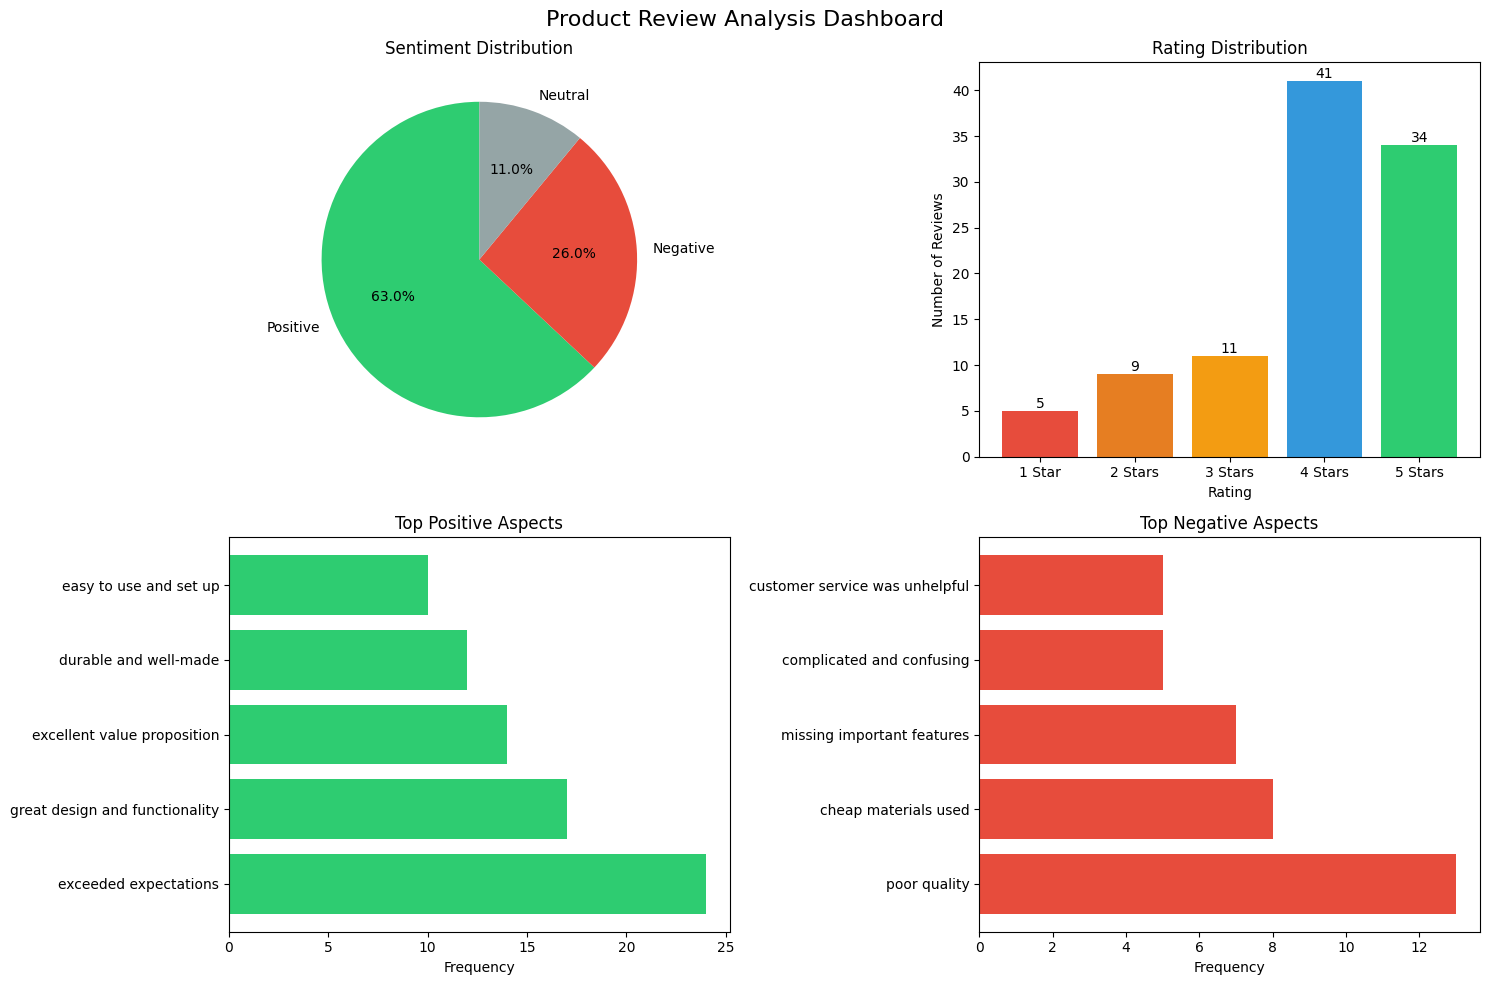

In [28]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from cerebras.cloud.sdk import Cerebras
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
MODEL_NAME = "llama-3.3-70b"
API_KEY = "API_KEY"
client = Cerebras(api_key=API_KEY)

# Generate sample reviews
def generate_sample_reviews(n=100):
    """Generate realistic product reviews for testing"""
    
    # Templates for different sentiment reviews
    positive_templates = [
        "This product is amazing! {detail}. Highly recommend!",
        "Exceeded my expectations. {detail}. Would buy again.",
        "Perfect! {detail}. 5 stars!",
        "Love it! {detail}. Best purchase ever.",
        "Outstanding quality. {detail}. Very satisfied.",
        "Fantastic product! {detail}. Worth every penny.",
        "Excellent! {detail}. Couldn't be happier.",
        "Great value for money. {detail}. Impressed!",
        "Superb! {detail}. Exactly what I needed.",
        "Brilliant product. {detail}. Highly satisfied."
    ]
    
    negative_templates = [
        "Terrible product. {detail}. Very disappointed.",
        "Complete waste of money. {detail}. Do not buy!",
        "Poor quality. {detail}. Returning it.",
        "Awful experience. {detail}. Not recommended.",
        "Disappointed. {detail}. Expected much better.",
        "Worst purchase ever. {detail}. Stay away!",
        "Useless product. {detail}. Total regret.",
        "Failed after one day. {detail}. Unacceptable.",
        "Not worth it. {detail}. Save your money.",
        "Horrible quality. {detail}. Very unhappy."
    ]
    
    neutral_templates = [
        "It's okay. {detail}. Average product.",
        "Not bad, not great. {detail}. Just fine.",
        "Mixed feelings. {detail}. Could be better.",
        "Decent product. {detail}. Nothing special.",
        "It works. {detail}. As expected.",
        "Fair product. {detail}. Some pros and cons.",
        "Acceptable. {detail}. Does the job.",
        "Neither impressed nor disappointed. {detail}.",
        "Average quality. {detail}. It's alright.",
        "Mediocre. {detail}. You get what you pay for."
    ]
    
    positive_details = [
        "The build quality is exceptional",
        "Customer service was very helpful",
        "Delivery was faster than expected",
        "The features work perfectly",
        "Great design and functionality",
        "Easy to use and set up",
        "Exceeded all my expectations",
        "The best in its category",
        "Durable and well-made",
        "Excellent value proposition"
    ]
    
    negative_details = [
        "Broke after just a week",
        "Customer service was unhelpful",
        "Delivery took forever",
        "Missing important features",
        "Cheap materials used",
        "Complicated and confusing",
        "Nothing like the description",
        "Overpriced for what you get",
        "Poor packaging, arrived damaged",
        "False advertising"
    ]
    
    neutral_details = [
        "Works as described",
        "Standard quality materials",
        "Delivery was on time",
        "Basic features included",
        "Simple design",
        "Instructions could be clearer",
        "Price is reasonable",
        "Packaging was adequate",
        "Does what it's supposed to",
        "No major complaints"
    ]
    
    reviews = []
    
    # Generate reviews with realistic distribution
    # 60% positive, 25% negative, 15% neutral
    sentiment_distribution = ['positive'] * 60 + ['negative'] * 25 + ['neutral'] * 15
    
    for i in range(n):
        sentiment = random.choice(sentiment_distribution)
        
        if sentiment == 'positive':
            template = random.choice(positive_templates)
            detail = random.choice(positive_details)
            rating = random.choice([4, 4, 5, 5, 5])  # Mostly 5 stars
        elif sentiment == 'negative':
            template = random.choice(negative_templates)
            detail = random.choice(negative_details)
            rating = random.choice([1, 1, 1, 2, 2])  # Mostly 1 star
        else:
            template = random.choice(neutral_templates)
            detail = random.choice(neutral_details)
            rating = 3
        
        review_text = template.format(detail=detail)
        
        # Add some variation
        if random.random() > 0.7:
            if sentiment == 'positive':
                review_text += " " + random.choice([
                    "Already recommended to friends.",
                    "Will definitely buy more.",
                    "Best decision I made.",
                    "Can't live without it now."
                ])
            elif sentiment == 'negative':
                review_text += " " + random.choice([
                    "Want my money back.",
                    "Never buying from them again.",
                    "Worst experience ever.",
                    "Complete disaster."
                ])
        
        # Generate random date within last 6 months
        days_ago = random.randint(1, 180)
        review_date = datetime.now() - timedelta(days=days_ago)
        
        reviews.append({
            'review_id': i + 1,
            'review_text': review_text,
            'rating': rating,
            'date': review_date.strftime('%Y-%m-%d'),
            'verified_purchase': random.choice([True, True, True, False]),  # 75% verified
            'helpful_votes': random.randint(0, 50)
        })
    
    return pd.DataFrame(reviews)

def analyze_reviews_batch(reviews_df):
    """Analyze all reviews together using Cerebras API"""
    
    # Combine all reviews into a single text
    all_reviews = "\n\n".join([
        f"Review {idx+1}: {row['review_text']} (Rating: {row['rating']}/5)"
        for idx, row in reviews_df.iterrows()
    ])
    
    prompt = f"""Analyze the following collection of {len(reviews_df)} product reviews and provide comprehensive statistics.

REVIEWS:
{all_reviews}

Please analyze these reviews and provide the following information in JSON format:

1. Sentiment Distribution:
   - Number and percentage of positive reviews
   - Number and percentage of negative reviews
   - Number and percentage of neutral reviews

2. Key Themes:
   - Top 5 positive aspects mentioned (with frequency)
   - Top 5 negative aspects mentioned (with frequency)
   - Most common complaints
   - Most praised features

3. Rating Analysis:
   - Average rating (should match the provided ratings)
   - Rating distribution (count for each star rating)

4. Customer Satisfaction Insights:
   - Overall satisfaction level (High/Medium/Low)
   - Would customers recommend this product? (Yes/No/Mixed)
   - Main reasons for satisfaction/dissatisfaction

5. Summary Statistics:
   - Total number of reviews analyzed
   - Average review length (in words)
   - Sentiment confidence score (0-100%)

Return ONLY a valid JSON object with this structure:
{{
    "total_reviews": number,
    "sentiment_distribution": {{
        "positive": {{"count": number, "percentage": number}},
        "negative": {{"count": number, "percentage": number}},
        "neutral": {{"count": number, "percentage": number}}
    }},
    "key_themes": {{
        "positive_aspects": [
            {{"aspect": "string", "frequency": number}},
            ...
        ],
        "negative_aspects": [
            {{"aspect": "string", "frequency": number}},
            ...
        ],
        "most_common_complaints": ["string", ...],
        "most_praised_features": ["string", ...]
    }},
    "rating_analysis": {{
        "average_rating": number,
        "distribution": {{
            "5_star": number,
            "4_star": number,
            "3_star": number,
            "2_star": number,
            "1_star": number
        }}
    }},
    "customer_satisfaction": {{
        "overall_level": "string",
        "would_recommend": "string",
        "main_satisfaction_reasons": ["string", ...],
        "main_dissatisfaction_reasons": ["string", ...]
    }},
    "summary_stats": {{
        "total_analyzed": number,
        "avg_review_length_words": number,
        "sentiment_confidence": number
    }}
}}"""

    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {
                    "role": "system",
                    "content": "You are a sentiment analysis expert. Always return valid JSON."
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            temperature=0.1,
            top_p=0.95
        )
        
        result_text = response.choices[0].message.content
        
        # Extract JSON from response
        if "```json" in result_text:
            result_text = result_text.split("```json")[1].split("```")[0].strip()
        elif "```" in result_text:
            result_text = result_text.split("```")[1].split("```")[0].strip()
        
        # Parse JSON
        analysis_result = json.loads(result_text)
        return analysis_result
        
    except Exception as e:
        print(f"Error in API call: {e}")
        return None

def visualize_results(reviews_df, analysis_result):
    """Create visualizations of the review analysis"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Product Review Analysis Dashboard', fontsize=16)
    
    # 1. Sentiment Distribution Pie Chart
    ax1 = axes[0, 0]
    sentiment_data = analysis_result['sentiment_distribution']
    labels = ['Positive', 'Negative', 'Neutral']
    sizes = [
        sentiment_data['positive']['percentage'],
        sentiment_data['negative']['percentage'],
        sentiment_data['neutral']['percentage']
    ]
    colors = ['#2ecc71', '#e74c3c', '#95a5a6']
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Sentiment Distribution')
    
    # 2. Rating Distribution Bar Chart
    ax2 = axes[0, 1]
    rating_dist = analysis_result['rating_analysis']['distribution']
    ratings = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']
    counts = [
        rating_dist['1_star'],
        rating_dist['2_star'],
        rating_dist['3_star'],
        rating_dist['4_star'],
        rating_dist['5_star']
    ]
    bars = ax2.bar(ratings, counts, color=['#e74c3c', '#e67e22', '#f39c12', '#3498db', '#2ecc71'])
    ax2.set_title('Rating Distribution')
    ax2.set_xlabel('Rating')
    ax2.set_ylabel('Number of Reviews')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    # 3. Top Positive Aspects
    ax3 = axes[1, 0]
    positive_aspects = analysis_result['key_themes']['positive_aspects'][:5]
    aspects = [item['aspect'] for item in positive_aspects]
    frequencies = [item['frequency'] for item in positive_aspects]
    ax3.barh(aspects, frequencies, color='#2ecc71')
    ax3.set_title('Top Positive Aspects')
    ax3.set_xlabel('Frequency')
    
    # 4. Top Negative Aspects
    ax4 = axes[1, 1]
    negative_aspects = analysis_result['key_themes']['negative_aspects'][:5]
    aspects = [item['aspect'] for item in negative_aspects]
    frequencies = [item['frequency'] for item in negative_aspects]
    ax4.barh(aspects, frequencies, color='#e74c3c')
    ax4.set_title('Top Negative Aspects')
    ax4.set_xlabel('Frequency')
    
    plt.tight_layout()
    return fig

def print_analysis_summary(analysis_result):
    """Print a formatted summary of the analysis"""
    
    print("\n" + "="*60)
    print("📊 PRODUCT REVIEW ANALYSIS SUMMARY")
    print("="*60)
    
    # Overall Statistics
    print(f"\n📈 OVERALL STATISTICS:")
    print(f"   Total Reviews Analyzed: {analysis_result['total_reviews']}")
    print(f"   Average Rating: {analysis_result['rating_analysis']['average_rating']:.2f}/5.0")
    print(f"   Sentiment Confidence: {analysis_result['summary_stats']['sentiment_confidence']}%")
    
    # Sentiment Distribution
    print(f"\n😊 SENTIMENT BREAKDOWN:")
    sent_dist = analysis_result['sentiment_distribution']
    print(f"   ✅ Positive: {sent_dist['positive']['count']} ({sent_dist['positive']['percentage']:.1f}%)")
    print(f"   ❌ Negative: {sent_dist['negative']['count']} ({sent_dist['negative']['percentage']:.1f}%)")
    print(f"   ➖ Neutral: {sent_dist['neutral']['count']} ({sent_dist['neutral']['percentage']:.1f}%)")
    
    # Customer Satisfaction
    print(f"\n🎯 CUSTOMER SATISFACTION:")
    cust_sat = analysis_result['customer_satisfaction']
    print(f"   Overall Satisfaction Level: {cust_sat['overall_level']}")
    print(f"   Would Recommend: {cust_sat['would_recommend']}")
    
    # Key Insights
    print(f"\n💡 KEY INSIGHTS:")
    print(f"\n   🌟 Most Praised Features:")
    for feature in analysis_result['key_themes']['most_praised_features'][:3]:
        print(f"      • {feature}")
    
    print(f"\n   ⚠️  Most Common Complaints:")
    for complaint in analysis_result['key_themes']['most_common_complaints'][:3]:
        print(f"      • {complaint}")
    
    print("\n" + "="*60)

# Main execution
if __name__ == "__main__":
    print("🚀 Starting Review Analysis System...")
    
    # Step 1: Generate sample reviews
    print("\n📝 Generating 100 sample reviews...")
    reviews_df = generate_sample_reviews(100)
    print(f"✅ Generated {len(reviews_df)} reviews")
    
    # Show sample of reviews
    print("\n📋 Sample Reviews:")
    for i in range(3):
        print(f"\nReview {i+1}:")
        print(f"   Text: {reviews_df.iloc[i]['review_text']}")
        print(f"   Rating: {'⭐' * reviews_df.iloc[i]['rating']}")
        print(f"   Date: {reviews_df.iloc[i]['date']}")
    
    # Step 2: Analyze reviews using Cerebras
    print("\n🤖 Analyzing reviews with Cerebras AI...")
    analysis_result = analyze_reviews_batch(reviews_df)
    
    if analysis_result:
        print("✅ Analysis complete!")
        
        # Step 3: Display results
        print_analysis_summary(analysis_result)
        
        # Step 4: Create visualizations
        print("\n📊 Creating visualizations...")
        fig = visualize_results(reviews_df, analysis_result)
        plt.savefig('review_analysis_dashboard.png', dpi=300, bbox_inches='tight')
        print("✅ Dashboard saved as 'review_analysis_dashboard.png'")
                
        # Create summary report
        summary_df = pd.DataFrame({
            'Metric': [
                'Total Reviews',
                'Average Rating',
                'Positive Reviews',
                'Negative Reviews',
                'Neutral Reviews',
                'Would Recommend',
                'Satisfaction Level'
            ],
            'Value': [
                analysis_result['total_reviews'],
                f"{analysis_result['rating_analysis']['average_rating']:.2f}",
                f"{analysis_result['sentiment_distribution']['positive']['count']} ({analysis_result['sentiment_distribution']['positive']['percentage']:.1f}%)",
                f"{analysis_result['sentiment_distribution']['negative']['count']} ({analysis_result['sentiment_distribution']['negative']['percentage']:.1f}%)",
                f"{analysis_result['sentiment_distribution']['neutral']['count']} ({analysis_result['sentiment_distribution']['neutral']['percentage']:.1f}%)",
                analysis_result['customer_satisfaction']['would_recommend'],
                analysis_result['customer_satisfaction']['overall_level']
            ]
        })
        summary_df.to_csv('analysis_summary.csv', index=False)
        print("✅ Summary saved to 'analysis_summary.csv'")
        
        # Show plot
        plt.show()
        
    else:
        print("❌ Analysis failed. Please check the error messages above.")
    

In [29]:
reviews_df

,review_id,review_text,rating,date,verified_purchase,helpful_votes
0,1,Exceeded my expectations. The best in its cate...,4,2025-04-03,True,43
1,2,Awful experience. Delivery took forever. Not r...,1,2025-02-04,True,41
2,3,Brilliant product. The features work perfectly...,4,2024-12-22,True,27
3,4,Excellent! Delivery was faster than expected. ...,4,2025-03-16,False,31
4,5,Poor quality. Overpriced for what you get. Ret...,2,2025-01-19,True,31
...,...,...,...,...,...,...
95,96,Acceptable. Price is reasonable. Does the job.,3,2025-02-06,False,12
96,97,Fantastic product! Customer service was very h...,5,2025-03-05,True,3
97,98,Fantastic product! The best in its category. W...,5,2025-01-30,True,20
98,99,Love it! The best in its category. Best purcha...,4,2025-03-30,True,15
